<a href="https://colab.research.google.com/github/2EDITH7/RAJNIKANT/blob/main/Stock_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# =========================
# 1) Imports & Setup
# =========================
import os
import json
import time
import random
import re
from dataclasses import dataclass, asdict
from typing import List, Tuple, Dict
from datetime import datetime, timezone
import pickle

import numpy as np
import pandas as pd
import yfinance as yf
import feedparser

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

# Ensure VADER is available
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon')

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [17]:
# =========================
# 2) Config
# =========================
@dataclass
class Config:
    tickers: List[str]
    start: str  # 'YYYY-MM-DD'
    end: str    # 'YYYY-MM-DD'
    lookback: int = 15          # LSTM sequence length
    horizon: int = 1            # Predict next-day movement
    test_size: float = 0.15     # Portion for final test (chronological)
    val_size: float = 0.15      # Portion of train for validation
    min_headlines_per_day: int = 0  # Filter days with fewer headlines
    sentiment_agg: str = 'mean'     # 'mean' or 'median'
    price_interval: str = '1d'
    results_dir: str = 'results'

CFG = Config(
    tickers=['AAPL','MSFT','GOOG','AMZN'],
    start='2020-01-01',
    end=datetime.now().strftime('%Y-%m-%d'),
)

os.makedirs(CFG.results_dir, exist_ok=True)
with open(os.path.join(CFG.results_dir, 'config.json'), 'w') as f:
    json.dump(asdict(CFG), f, indent=2)


In [18]:
# =========================
# 3) Data: Price & Headlines
# =========================

def fetch_price_data(tickers: List[str], start: str, end: str, interval: str='1d') -> pd.DataFrame:
    """
    Download OHLCV and Adj Close.
    MODIFIED: This function is now robust and ensures the output column format
    is always a MultiIndex with ('Ticker', 'Field'), which prevents KeyErrors.
    """
    data = yf.download(tickers, start=start, end=end, interval=interval, auto_adjust=False, progress=False)
    if data.empty:
        raise ValueError("No data fetched. Check tickers and date range.")

    # Check if the returned columns are already a MultiIndex (multi-ticker case)
    if isinstance(data.columns, pd.MultiIndex):
        # yfinance returns ('Field', 'Ticker'), so we swap to ('Ticker', 'Field')
        px = data.swaplevel(axis=1)

    else:
        # yfinance returns a flat DataFrame (single-ticker case), so we create the MultiIndex
        px = pd.concat([data], keys=tickers, axis=1)

    # Sort columns for consistent ordering
    px = px.sort_index(axis=1)

    # Forward-fill missing values per ticker, addressing the deprecation warning
    # This ensures that for each ticker, any NaN values are filled from the previous day
    px = px.T.groupby(level=0).ffill().T
    return px





YAHOO_RSS = "https://feeds.finance.yahoo.com/rss/2.0/headline?s={ticker}&region=US&lang=en-US"


_rss_date_formats = [
    '%a, %d %b %Y %H:%M:%S %z',
    '%a, %d %b %Y %H:%M:%S %Z',
]

def _parse_rss_datetime(s: str):
    for fmt in _rss_date_formats:
        try:
            return datetime.strptime(s, fmt)
        except ValueError:
            continue
    try:
        # Fallback for other formats pandas can handle
        return pd.to_datetime(s).to_pydatetime()
    except Exception:
        return None

_clean_re = re.compile(r"\s+")

def fetch_rss_headlines_for_ticker(ticker: str, start: str, end: str) -> pd.DataFrame:
    feed_url = YAHOO_RSS.format(ticker=ticker)
    feed = feedparser.parse(feed_url)
    rows = []
    dt_start = pd.to_datetime(start).tz_localize('UTC')
    dt_end = pd.to_datetime(end).tz_localize('UTC') + pd.Timedelta(days=1)

    for e in getattr(feed, 'entries', []):
        title = e.get('title', '')
        published = e.get('published') or e.get('updated')
        if not title or not published:
            continue
        dt = _parse_rss_datetime(published)
        if dt is None:
            continue
        if dt.tzinfo is None:
            dt = dt.replace(tzinfo=timezone.utc)
        else:
            dt = dt.astimezone(timezone.utc)
        if not (dt_start <= dt < dt_end):
            continue
        rows.append({
            'ticker': ticker,
            'datetime_utc': dt,
            'date': dt.date(),
            'headline': _clean_re.sub(' ', title).strip(),
            'link': e.get('link', ''),
        })
    return pd.DataFrame(rows)


def fetch_all_headlines(tickers: List[str], start: str, end: str) -> pd.DataFrame:
    frames = []
    for t in tickers:
        try:
            print(f"Fetching headlines for {t}...")
            df = fetch_rss_headlines_for_ticker(t, start, end)
            frames.append(df)
            time.sleep(0.2)
        except Exception as ex:
            print(f"[WARN] RSS fetch failed for {t}: {ex}")
    if not frames:
        return pd.DataFrame(columns=['ticker','datetime_utc','date','headline','link'])
    return pd.concat(frames, ignore_index=True)

In [19]:
# =========================
# 4) Sentiment (VADER)
# =========================

def add_vader_sentiment(df_news: pd.DataFrame) -> pd.DataFrame:
    if df_news.empty:
        return df_news.assign(pos=np.nan, neu=np.nan, neg=np.nan, compound=np.nan)
    sid = SentimentIntensityAnalyzer()
    scores = df_news['headline'].apply(lambda x: sid.polarity_scores(str(x)))
    sent_df = pd.DataFrame(list(scores))
    return pd.concat([df_news.reset_index(drop=True), sent_df], axis=1)


def aggregate_daily_sentiment(df_news_sent: pd.DataFrame, agg: str='mean', min_count: int=0) -> pd.DataFrame:
    if df_news_sent.empty:
        cols = pd.MultiIndex.from_product([CFG.tickers, ['pos','neu','neg','compound','count']])
        idx = pd.DatetimeIndex([], name='Date')
        return pd.DataFrame(columns=cols, index=idx)

    agg_funcs = {'pos': agg, 'neu': agg, 'neg': agg, 'compound': agg}
    grouped = (df_news_sent
               .groupby(['ticker','date'])[['pos','neu','neg','compound']]
               .agg(agg_funcs)
               .reset_index())
    counts = (df_news_sent.groupby(['ticker','date'])['headline']
              .count().reset_index(name='count'))
    merged = pd.merge(grouped, counts, on=['ticker','date'], how='left')

    if min_count > 0:
        merged = merged[merged['count'] >= min_count]

    pivot = merged.pivot(index='date', columns='ticker', values=['pos','neu','neg','compound','count'])
    pivot.index = pd.to_datetime(pivot.index)
    pivot.index.name = 'Date'
    pivot = pivot.swaplevel(axis=1).sort_index(axis=1)
    return pivot


In [20]:
# =========================
# 5) Technical Features & Labels (per ticker)
# =========================

def make_technical_features(px: pd.DataFrame, ticker: str) -> pd.DataFrame:
    # This now works because px has the consistent ('Ticker', 'Field') structure
    close = px[(ticker, 'Adj Close')].copy()
    ret = close.pct_change()
    sma5 = close.rolling(5).mean()
    sma10 = close.rolling(10).mean()
    # RSI(14)
    delta = close.diff()
    gain = (delta.where(delta>0, 0.0)).rolling(14).mean()
    loss = (-delta.where(delta<0, 0.0)).rolling(14).mean()
    rs = gain / loss
    rsi14 = 100 - (100 / (1 + rs))
    # MACD(12,26,9)
    macd = close.ewm(span=12, adjust=False).mean() - close.ewm(span=26, adjust=False).mean()
    signal = macd.ewm(span=9, adjust=False).mean()
    df = pd.DataFrame({
        'ret1': ret,
        'sma5': sma5,
        'sma10': sma10,
        'sma_gap': (sma5 - sma10) / sma10,
        'rsi14': rsi14,
        'macd': macd,
        'macd_signal': signal,
        'volume': px[(ticker,'Volume')].rolling(5).mean(),
    }, index=close.index)
    return df


def build_dataset_for_ticker(ticker: str, px: pd.DataFrame, daily_sent: pd.DataFrame, horizon: int) -> Tuple[pd.DataFrame, pd.Series]:
    tech = make_technical_features(px, ticker)
    # Sentiment subset for this ticker
    sent_cols = [(ticker, c) for c in ['pos','neu','neg','compound','count'] if (ticker, c) in daily_sent.columns]
    if not sent_cols:
        # Handle case where no sentiment data exists for a ticker
        sent = pd.DataFrame(index=tech.index)
    else:
        sent = daily_sent[sent_cols]
        # Flatten MultiIndex columns for sentiment
        sent.columns = [c[1] for c in sent.columns]

    # Merge on date index
    features = pd.concat([tech, sent], axis=1).sort_index()

    # Fill sentiment NaNs with 0 (neutral) after merging with tech data
    sent_feature_cols = ['pos', 'neu', 'neg', 'compound', 'count']
    for col in sent_feature_cols:
        if col in features.columns:
            features[col] = features[col].fillna(0)

    # Label: next-day up move on Adj Close
    close = px[(ticker,'Adj Close')]
    fut_ret = close.pct_change(periods=horizon).shift(-horizon)
    y = (fut_ret > 0).astype(int)

    df_all = pd.concat([features, y.rename('target')], axis=1).dropna()
    X = df_all.drop(columns=['target'])
    y = df_all['target']
    return X, y


In [21]:
# =========================
# 6) Chrono Split & Sequences
# =========================

def chrono_split(X: pd.DataFrame, y: pd.Series, val_size: float, test_size: float):
    n = len(X)
    n_test = int(n * test_size)
    n_val = int((n - n_test) * val_size)
    n_train = n - n_test - n_val
    return (
        X.iloc[:n_train], y.iloc[:n_train],
        X.iloc[n_train:n_train+n_val], y.iloc[n_train:n_train+n_val],
        X.iloc[n_train+n_val:], y.iloc[n_train+n_val:]
    )


def to_sequences(X_arr: np.ndarray, y_arr: np.ndarray, lookback: int):
    # REVERTED: This is the original, correct logic.
    # The target y[i] corresponds to the sequence of features X[i-lookback : i]
    X_seq, y_seq = [], []
    for i in range(lookback, len(X_arr)):
        X_seq.append(X_arr[i-lookback:i])
        y_seq.append(y_arr[i])
    return np.array(X_seq), np.array(y_seq)

In [22]:
# =========================
# 7) Model Building & Random Search
# =========================

def build_lstm_model(input_shape, units=64, dropout=0.2, lr=1e-3):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(units),
        layers.Dropout(dropout),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model


def random_search_lstm(X_train, y_train, X_val, y_val, param_grid: Dict, max_trials: int=6, epochs: int=30):
    best = {'score': -np.inf, 'params': None, 'model': None}
    tried = set()
    trials = 0
    input_shape = X_train.shape[1:]

    if len(X_val) == 0:
        print("[WARN] Validation set is empty. Skipping hyperparameter search.")
        # Fallback to default parameters
        default_params = {k: v[0] for k, v in param_grid.items()}
        model = build_lstm_model(input_shape, **{k:v for k,v in default_params.items() if k in ['units','dropout','lr']})
        return {'score': 0, 'params': default_params, 'model': model}

    while trials < max_trials:
        units = random.choice(param_grid['units'])
        dropout = random.choice(param_grid['dropout'])
        lr = random.choice(param_grid['lr'])
        batch_size = random.choice(param_grid['batch_size'])
        key = (units, dropout, lr, batch_size)
        if key in tried:
            continue
        tried.add(key)
        trials += 1
        print(f"[Trial {trials}/{max_trials}] units={units}, dropout={dropout}, lr={lr}, batch={batch_size}")

        model = build_lstm_model(input_shape, units, dropout, lr)
        es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)
        hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs,
                         batch_size=batch_size, verbose=0, callbacks=[es])
        val_acc = max(hist.history['val_accuracy'])
        print(f"  -> val_acc={val_acc:.4f}")
        if val_acc > best['score']:
            best = {'score': val_acc, 'params': {'units':units,'dropout':dropout,'lr':lr,'batch_size':batch_size}, 'model': model}

    return best



In [23]:
# =========================
# 8) Training/Evaluation per Ticker
# =========================

def train_evaluate_for_ticker(ticker: str, px: pd.DataFrame, daily_sent: pd.DataFrame, cfg: Config):
    print(f"\n===== Ticker: {ticker} =====")
    X, y = build_dataset_for_ticker(ticker, px, daily_sent, cfg.horizon)

    X_tr, y_tr, X_va, y_va, X_te, y_te = chrono_split(X, y, cfg.val_size, cfg.test_size)

    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_va_s = scaler.transform(X_va)
    X_te_s = scaler.transform(X_te)

    X_tr_seq, y_tr_seq = to_sequences(X_tr_s, y_tr.values, cfg.lookback)

    X_va_full = np.vstack([X_tr_s, X_va_s])
    y_va_full = np.hstack([y_tr.values, y_va.values])
    X_va_seq_all, y_va_seq_all = to_sequences(X_va_full, y_va_full, cfg.lookback)

    # Isolate only the validation sequences
    n_train_seq = len(y_tr_seq)
    X_va_seq = X_va_seq_all[n_train_seq:]
    y_va_seq = y_va_seq_all[n_train_seq:]

    X_te_full = np.vstack([X_va_s, X_te_s])
    y_te_full = np.hstack([y_va.values, y_te.values])
    X_te_seq_all, y_te_seq_all = to_sequences(X_te_full, y_te_full, cfg.lookback)
    n_val_seq = X_te_full.shape[0] - cfg.lookback - X_te_s.shape[0]
    X_te_seq = X_te_seq_all[n_val_seq:]
    y_te_seq = y_te_seq_all[n_val_seq:]


    if len(X_tr_seq) < 10 or len(X_va_seq) < 5 or len(X_te_seq) < 5:
        print("[WARN] Not enough data for sequences after split. Consider reducing lookback or changing dates.")
        return None

    param_grid = {
        'units': [32, 64, 96],
        'dropout': [0.1, 0.2, 0.3],
        'lr': [1e-3, 5e-4],
        'batch_size': [32, 64]
    }
    best = random_search_lstm(X_tr_seq, y_tr_seq, X_va_seq, y_va_seq, param_grid, max_trials=6, epochs=35)
    best_params = best['params']

    X_trva_s = np.vstack([X_tr_s, X_va_s])
    y_trva = np.hstack([y_tr.values, y_va.values])
    X_trva_seq, y_trva_seq = to_sequences(X_trva_s, y_trva, cfg.lookback)

    final_model_params = {k: v for k, v in best_params.items() if k in ['units', 'dropout', 'lr']}
    final_model = build_lstm_model(X_trva_seq.shape[1:], **final_model_params)
    final_model.fit(X_trva_seq, y_trva_seq, validation_split=0.1, epochs=50,
                    batch_size=best_params['batch_size'], verbose=0,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, mode='max', restore_best_weights=True)])

    y_proba = final_model.predict(X_te_seq, verbose=0).squeeze()
    y_pred = (y_proba >= 0.5).astype(int)

    acc = accuracy_score(y_te_seq, y_pred)
    prec = precision_score(y_te_seq, y_pred, zero_division=0)
    rec = recall_score(y_te_seq, y_pred, zero_division=0)
    f1 = f1_score(y_te_seq, y_pred, zero_division=0)

    print("\n=== Test Metrics ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_te_seq, y_pred, digits=4, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_te_seq, y_pred))

    model_path = os.path.join(cfg.results_dir, f'{ticker}_lstm_sentiment_model.keras')
    scaler_path = os.path.join(cfg.results_dir, f'{ticker}_scaler.pkl')
    final_model.save(model_path)
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)

    plt.figure(figsize=(10, 5))
    plt.plot(y_proba, label=f'Pred. Prob(UP)', alpha=0.7)
    plt.hlines(0.5, 0, len(y_proba), colors='r', linestyles='--', label='0.5 Threshold')
    plt.title(f'{ticker}: Predicted Up-Probability on Test Set')
    plt.xlabel('Test Sequence Index')
    plt.ylabel('Probability')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'ticker': ticker,
        'test_metrics': {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1},
        'best_params': best_params,
        'model_path': model_path,
        'scaler_path': scaler_path
    }



In [24]:
# =========================
# 9) Main Pipeline
# =========================

def run_pipeline(cfg: Config):
    # Prices
    print("Fetching price data...")
    px = fetch_price_data(cfg.tickers, cfg.start, cfg.end, cfg.price_interval)

    # Headlines + Sentiment
    print("Fetching and processing news headlines...")
    news = fetch_all_headlines(cfg.tickers, cfg.start, cfg.end)
    news_sent = add_vader_sentiment(news)
    daily_sent = aggregate_daily_sentiment(news_sent, agg=cfg.sentiment_agg, min_count=cfg.min_headlines_per_day)

    # Align sentiment to price calendar (forward-fill weekends/holidays)
    daily_sent = daily_sent.reindex(px.index).ffill()

    # Train/Eval per ticker
    results = {}
    for t in cfg.tickers:
        out = train_evaluate_for_ticker(t, px, daily_sent, cfg)
        if out:
            results[t] = out

    return results

Fetching price data...
Fetching and processing news headlines...
Fetching headlines for AAPL...
Fetching headlines for MSFT...
Fetching headlines for GOOG...
Fetching headlines for AMZN...

===== Ticker: AAPL =====
[Trial 1/6] units=96, dropout=0.1, lr=0.001, batch=64
  -> val_acc=0.3989
[Trial 2/6] units=96, dropout=0.3, lr=0.001, batch=64
  -> val_acc=0.3933
[Trial 3/6] units=32, dropout=0.2, lr=0.0005, batch=32
  -> val_acc=0.4775
[Trial 4/6] units=64, dropout=0.1, lr=0.001, batch=64
  -> val_acc=0.4551
[Trial 5/6] units=64, dropout=0.3, lr=0.0005, batch=32
  -> val_acc=0.3820
[Trial 6/6] units=32, dropout=0.3, lr=0.0005, batch=64
  -> val_acc=0.5618

=== Test Metrics ===
Accuracy : 0.4762
Precision: 0.5278
Recall   : 0.1696
F1-score : 0.2568

Classification Report:
               precision    recall  f1-score   support

           0     0.4655    0.8265    0.5956        98
           1     0.5278    0.1696    0.2568       112

    accuracy                         0.4762       210
 

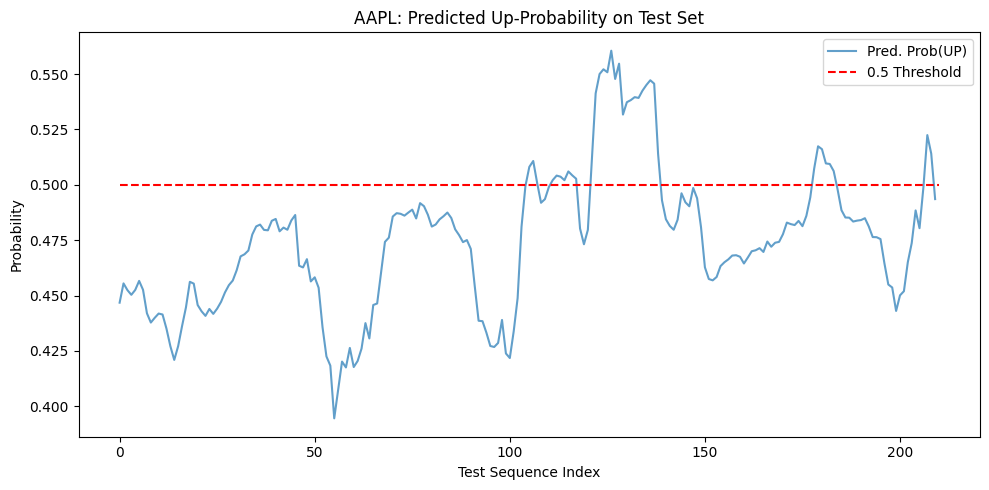


===== Ticker: MSFT =====
[Trial 1/6] units=32, dropout=0.2, lr=0.0005, batch=64
  -> val_acc=0.5225
[Trial 2/6] units=32, dropout=0.3, lr=0.0005, batch=32
  -> val_acc=0.5225
[Trial 3/6] units=96, dropout=0.3, lr=0.001, batch=64
  -> val_acc=0.5112
[Trial 4/6] units=32, dropout=0.1, lr=0.0005, batch=32
  -> val_acc=0.5112
[Trial 5/6] units=64, dropout=0.1, lr=0.0005, batch=32
  -> val_acc=0.5169
[Trial 6/6] units=96, dropout=0.2, lr=0.0005, batch=64
  -> val_acc=0.5169

=== Test Metrics ===
Accuracy : 0.4952
Precision: 0.5447
Recall   : 0.5726
F1-score : 0.5583

Classification Report:
               precision    recall  f1-score   support

           0     0.4253    0.3978    0.4111        93
           1     0.5447    0.5726    0.5583       117

    accuracy                         0.4952       210
   macro avg     0.4850    0.4852    0.4847       210
weighted avg     0.4918    0.4952    0.4931       210

Confusion Matrix:
 [[37 56]
 [50 67]]


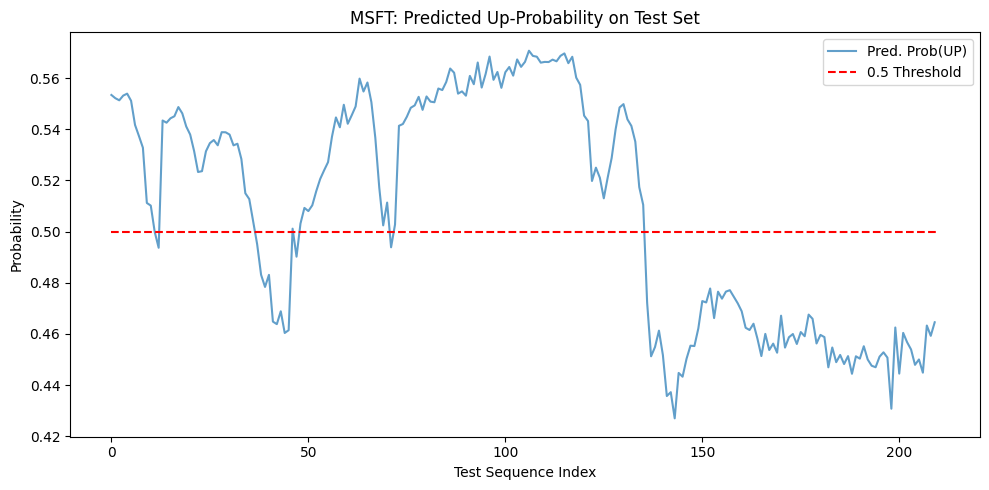


===== Ticker: GOOG =====
[Trial 1/6] units=96, dropout=0.2, lr=0.001, batch=64
  -> val_acc=0.6124
[Trial 2/6] units=32, dropout=0.3, lr=0.001, batch=64
  -> val_acc=0.6180
[Trial 3/6] units=32, dropout=0.2, lr=0.001, batch=64
  -> val_acc=0.6236
[Trial 4/6] units=96, dropout=0.2, lr=0.001, batch=32
  -> val_acc=0.6348
[Trial 5/6] units=96, dropout=0.1, lr=0.0005, batch=64
  -> val_acc=0.6011
[Trial 6/6] units=64, dropout=0.1, lr=0.001, batch=32
  -> val_acc=0.6180



=== Test Metrics ===
Accuracy : 0.5238
Precision: 0.5311
Recall   : 0.8468
F1-score : 0.6528

Classification Report:
               precision    recall  f1-score   support

           0     0.4848    0.1616    0.2424        99
           1     0.5311    0.8468    0.6528       111

    accuracy                         0.5238       210
   macro avg     0.5080    0.5042    0.4476       210
weighted avg     0.5093    0.5238    0.4593       210

Confusion Matrix:
 [[16 83]
 [17 94]]


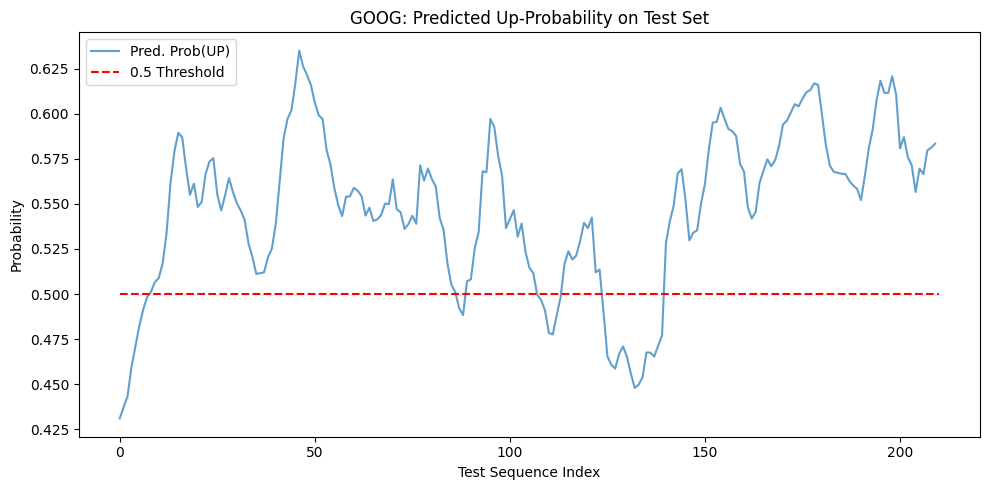


===== Ticker: AMZN =====
[Trial 1/6] units=32, dropout=0.3, lr=0.0005, batch=32
  -> val_acc=0.5449
[Trial 2/6] units=96, dropout=0.3, lr=0.001, batch=64
  -> val_acc=0.5225
[Trial 3/6] units=96, dropout=0.2, lr=0.001, batch=32
  -> val_acc=0.5337
[Trial 4/6] units=32, dropout=0.3, lr=0.001, batch=32
  -> val_acc=0.5562
[Trial 5/6] units=32, dropout=0.2, lr=0.001, batch=32
  -> val_acc=0.5169
[Trial 6/6] units=96, dropout=0.3, lr=0.0005, batch=32
  -> val_acc=0.5449



=== Test Metrics ===
Accuracy : 0.4952
Precision: 0.5556
Recall   : 0.2252
F1-score : 0.3205

Classification Report:
               precision    recall  f1-score   support

           0     0.4788    0.7980    0.5985        99
           1     0.5556    0.2252    0.3205       111

    accuracy                         0.4952       210
   macro avg     0.5172    0.5116    0.4595       210
weighted avg     0.5194    0.4952    0.4516       210

Confusion Matrix:
 [[79 20]
 [86 25]]


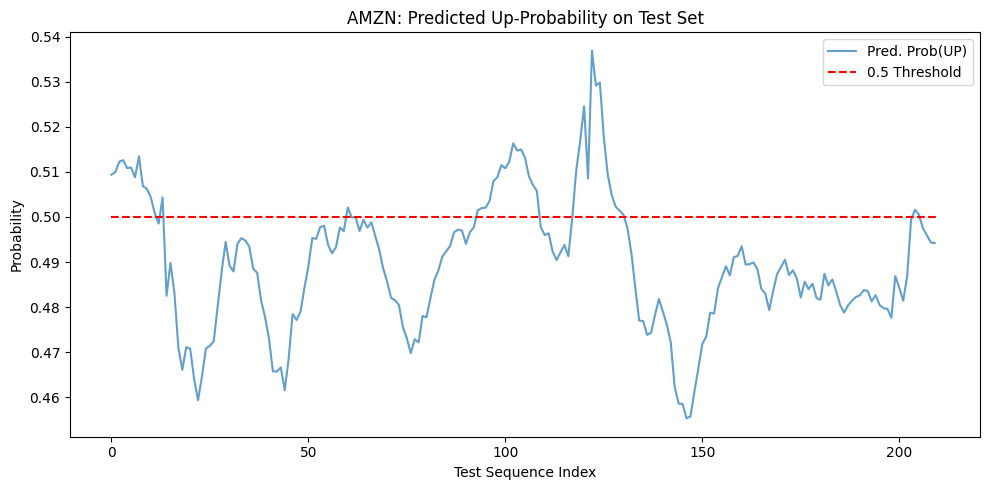


Artifacts saved to: results
{
  "AAPL": {
    "ticker": "AAPL",
    "test_metrics": {
      "accuracy": 0.47619047619047616,
      "precision": 0.5277777777777778,
      "recall": 0.16964285714285715,
      "f1": 0.25675675675675674
    },
    "best_params": {
      "units": 32,
      "dropout": 0.3,
      "lr": 0.0005,
      "batch_size": 64
    },
    "model_path": "results/AAPL_lstm_sentiment_model.keras",
    "scaler_path": "results/AAPL_scaler.pkl"
  },
  "MSFT": {
    "ticker": "MSFT",
    "test_metrics": {
      "accuracy": 0.49523809523809526,
      "precision": 0.5447154471544715,
      "recall": 0.5726495726495726,
      "f1": 0.5583333333333333
    },
    "best_params": {
      "units": 32,
      "dropout": 0.2,
      "lr": 0.0005,
      "batch_size": 64
    },
    "model_path": "results/MSFT_lstm_sentiment_model.keras",
    "scaler_path": "results/MSFT_scaler.pkl"
  },
  "GOOG": {
    "ticker": "GOOG",
    "test_metrics": {
      "accuracy": 0.5238095238095238,
      "prec

In [25]:
# =========================
# 10) Run
# =========================
if __name__ == '__main__':
    results = run_pipeline(CFG)
    print("\nArtifacts saved to:", CFG.results_dir)
    print(json.dumps(results, indent=2, default=str))
